# Grand débat : organisation des services publics - Topics Modeling

## Dependancies

In [1]:
import sparknlp
spark =  sparknlp.start()

## PYSPARK
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml import Pipeline as sparkMlPipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.clustering import LDA, LDAModel
from pyspark.ml.feature import CountVectorizer, IDF


## SPARK-NLP
from sparknlp.annotator import *
from sparknlp.base import *
from sparknlp.common import *


## PYTHON
# Basis
import sys
import numpy as np
import datetime
# Text treatment
import re
import unidecode
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
# Dataviz
import geopandas as gpd
import folium
from folium import plugins as foliumplugins
import pandas as pd


print("PYTHON VERSION: {}".format(sys.version.split()[0]))
print("SPARK VERSION: {}".format(sc.version))
print("SPARK-NLP VERSION: {}".format(sparknlp.version()))

PYTHON VERSION: 3.6.8
SPARK VERSION: 2.4.4
SPARK-NLP VERSION: 2.3.4


## Prepare raw data 

In [2]:
print("Start to extract raw data", datetime.datetime.now())

# Data location
bucket ='chau-testbucket'
data_key ='ORGANISATION_DE_LETAT_ET_DES_SERVICES_PUBLICS.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

# Import data
df = spark.read.option("header", "true")\
               .option("multiLine", True)\
               .option("sep",",")\
               .option("escape","\"")\
               .option("encoding","utf-8")\
               .csv(data_location)

# If 111953 => ok
print("Number of rows: {}".format(df.count()))

df = df.withColumn("n_row", F.monotonically_increasing_id())

for name in df.columns:
    df = df.withColumnRenamed(name, name.split("-")[0].strip() if "-" in name else name)

# Correct author type    
# If author type is null => "Inconnu"    
df = df.na.fill({'authorType': "Inconnu"})

# Correct zip-code
df = df.withColumn("authorZipCode", F.when(F.length(df.authorZipCode) != 5 ,None).otherwise(df.authorZipCode))

# Extract Departement from zip-code
df = df.withColumn("department", F.when(F.isnull(df.authorZipCode),None).otherwise(F.substring(df.authorZipCode,1,2)))


# Special case: DOM TOM
# DOM zip-code start with "97", and DOM with "98"
# In this case the department code correspond to the first three figures of the zip-code
df = df.withColumn("department", F.when((df.department==97)|(df.department==98),F.substring(df.authorZipCode,1,3))\
                                           .otherwise(df.department))

# Special Case: Corse
# Zip-code from Corse start with "20"
# Then if 20000 <= zip-code < 20200 => department = 2A (South Corse)
# If 20200 <= zip-code < 21000 => department = 2B (North Corse)
df = df.withColumn("department", F.when((df.department==20)&(df.authorZipCode<20200),"2A")\
                                    .otherwise(F.when((df.department==20)&(df.authorZipCode>=20200),"2B")\
                                               .otherwise(df.department)))

# Remove invalid department :if invalid => null value
valid_dep = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16",
             "17", "18", "19", "2A", "2B", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31",
             "32", "33", "34", "35", "36", "37", "38", "39", "40", "41", "42", "43", "44", "45", "46", "47",
             "48", "49", "50", "51", "52", "53", "54", "55", "56", "57", "58", "59", "60", "61", "62", "63",
             "64", "65", "66", "67", "68", "69", "70", "71", "72", "73", "74", "75", "76", "77", "78", "79",
             "80", "81", "82", "83", "84", "85", "86", "87", "88", "89", "90", "91", "92", "93", "94", "95",
             "971", "972", "973", "974", "975", "976", "977", "978", "984", "986", "987", "988", "989"]

df = df.withColumn("department", F.when(df.department.isin(valid_dep),df.department).otherwise(None))


# If department invalid => zip-code invalid
# So if department == null , => zip-code = null
df =  df.withColumn("authorZipCode",F.when(F.isnull(df.department),None).otherwise(df.authorZipCode))


# Get departemental arrondissement from zipcode

# Import correlation table between zip-code and departemental arrondissment
# Please note that one zip-code could correspond to multiple (small) cities
# Sometimes two cities with the same zip-code can belong to two different arrondissements
# However for convenience, and because this happens only when a city is at the border of an arrondissement,
# this case was not taken into account here. The arrondissement attributed to a zip-code is the most
# attributed to the cities that share this zip-code.

arr_key ='corresp_arrondissement_code_postal.csv'
arr_location = 's3://{}/{}'.format(bucket, arr_key)
arr_df = spark.read.option("header", "true").csv(arr_location)

# Join with our data
df = df.join(arr_df, arr_df.code_postal == df.authorZipCode, how="left")




# Columns to keep ?

# Targeted questions :
# QUXVlc3Rpb246MTY5 - Que pensez-vous de l'organisation de l'Etat et des administrations en France ? De quelle manière cette organisation devrait-elle évoluer ?
# QUXVlc3Rpb246MjA0 - Estimez-vous avoir accès aux services publics dont vous avez besoin ? => "Oui" ou "Non"
# QUXVlc3Rpb246MTcy - Si non, quels types de services publics vous manquent dans votre territoire et qu'il est nécessaire de renforcer ?
# QUXVlc3Rpb246MTc4 - Quand vous pensez à l'évolution des services publics au cours des dernières années, quels sont ceux qui ont évolué de manière positive ?
# QUXVlc3Rpb246MTc5 - Quels sont les services publics qui doivent le plus évoluer selon vous ?
# QUXVlc3Rpb246MTk1 - Si vous avez été amené à demander un remboursement de soins de santé, pouvez-vous indiquer les éléments de satisfaction et/ou les difficultés rencontrés en précisant, pour chaque point, l'administration concernée :
# QUXVlc3Rpb246MTk2 - Si vous avez été amené à faire une demande d'aide pour une situation de handicap, pouvez-vous indiquer les éléments de satisfaction et/ou les difficultés rencontrés en précisant, pour chaque point, l'administration concernée :
# QUXVlc3Rpb246MTg5 - Y a-t-il d'autres points sur l'organisation de l'Etat et des services publics sur lesquels vous souhaiteriez vous exprimer

select_var = {  
                "n_row": "id",
                "department": "department",
                "authorZipCode":"zip_code",
                "authorType": "author_type",
                "code_arr":"code_arr",
                "QUXVlc3Rpb246MTY5": "q_org",
                "QUXVlc3Rpb246MjA0": "q_access",
                "QUXVlc3Rpb246MTcy": "q_need_more",
                "QUXVlc3Rpb246MTc4": "q_positive_change",
                "QUXVlc3Rpb246MTc5": "q_need_change",
                "QUXVlc3Rpb246MTk1": "q_healthcare_refund",
                "QUXVlc3Rpb246MTk2": "q_disability",
                "QUXVlc3Rpb246MTg5": "q_open" 
            }

# Select the targeted columns, and rename them
df = df.select(*select_var.keys())
for k,v in select_var.items():
    df = df.withColumnRenamed(k, v)
    
# df.printSchema()

# Columns corresponding to a question
questions_col = [name for name in df.columns if name[0]=="q"]
# Columns not corresponding to a question
info_col = [name for name in df.columns if name[0]!="q"]

# Descriptives stats
# df.groupby("zip_code").agg(F.count("id").alias("n")).orderBy("n", ascending=False).show(truncate=False)
# df.groupby("author_type").agg(F.count("id").alias("n")).orderBy("n", ascending=False).show(truncate=False)


# How many null values in each column ?
# df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in questions_col]).show()
# df.select([F.isnull(c).alias(c) for c in ["q_access","q_need_more"]]).crosstab("q_access", "q_need_more").show()
# df.filter((df.q_access=="Oui")&(~F.isnull("q_need_more"))).select("id", "q_need_more").show(5, truncate=False)


print("Prepare raw data",datetime.datetime.now())
#target = ["q_need_more", "q_access"]
target = ["q_need_more"]
df_need = df.select(*(info_col+target))
df_need = df_need.dropna(subset=target)

# Remove the answers of people who previously said they don't lack access to public services
#df_need = df_need.filter(df_need.q_access == "Non")

# Remove too long answers
df_need = df_need.withColumn("text_len", F.length(df_need.q_need_more))
print("Numbers of answers before filter: {}".format(df_need.count()))
df_need = df_need.filter(df_need.text_len < 1000)

print("Numbers of answers at the end: {}".format(df_need.count()))

Start to extract raw data 2020-02-03 14:36:24.569014
Number of rows: 111953
Prepare raw data 2020-02-03 14:36:38.122428
Numbers of answers before filter: 34981
Numbers of answers at the end: 34433


## Feature Engineering

In [3]:
# Stopwords

print("Import StopWords",datetime.datetime.now())

# Stopwords location
stpw_key ='stopwords-fr.txt'
stpw_location = 's3://{}/{}'.format(bucket, stpw_key)

stopwords_fr = sqlContext.read.csv(stpw_location, header=False,  inferSchema=True).collect()
stopwords_fr = [ w._c0 for w in stopwords_fr]

# Alternatives
# import nltk
# nltk.download('stopwords')
# stopwords_fr = nltk.corpus.stopwords.words('french')

# from pyspark.ml.feature import StopWordsRemover
# len(StopWordsRemover.loadDefaultStopWords('french'))

# Add some custom stop words
custom = [
          "jamais", 
          "partout",
          "idem",
          "france", "français",
          "pouvoir", "peux", "peut", "pouvons", "pourrions", "peuvent", "pu", "pourrait", "pourraient",
          "dire", "dit", "dites", "dits", "dite", "dis", "disons",
          "devoir", "dois", "doit", "du", "dus", "dues", "due", "devons", "doivent", "devrait", "devraient", 
          "voir", "vu", "voit", "voient", "vois", "vus", "vue", "vues",
          "petit", "petits", "petite", "petits", "petites",
          "grand", "grande", "grands", "grandes",
          "presque",
          "oui", "non",
          "faire", "fais", "fait", "faisons", "faîtes", "fait", "faits", "faite", "faites", "font",
          "mettre", "mis", "met", "mets", "mise", "mises",
          "prendre", "pris", "prise", "prises", "prend", "prends", "prenons", "prennent", 
          "fin", "a priori", "priori",
          "face",
          "savoir", "sait", "sais", "savons", "sache", "sachent",
          "permettre", "permis", "permise", "permet", "permettent", "permises", "permetterait", "permette",
          "vouloir", "veut", "voulait", "veux", "voulu", "voulaient", "veulent", "voulons",
          "aller", "va", "allé", "allés", "allée", "allées", "vont", 
          "service", "services",
          "public", "publique", "publiques", "publics",
          "vis",
          "end", "ends",
          "accès", "besoin", "besoins", "problèmes", "problème",
          "exemple", "exemples", "ex", "cas", "situations", "situation",
    
    
#           "manque", "manquent", "manquer", "manqué", "manquant", "manquante", "manquantes", "manquants",
#           "suppressions", "suppression", "supprimer", "supprimés", "supprimées", "supprimée", "supprimé",
#           "disparition", "disparitions", "disparus", "disparu", "disparue", "disparues", "disparaitre",
#           "difficiles", "difficultés",
#           "problèmes", "problème",
#           "suffisament",

#           "personnel", "personnels", "effectif", "effectifs",    
#           "administration", "administratif", "administrative", "administratifs", "administratives",
#           "manque", "manquent", "manquer",
#           "renforcer", "renforce", "renforcé", "renforcés", "renforcée", "renforcées",
#           "réponse", "réponds", "répondre", "réponses", 
#           "concerne",
#           "moyen", "moyens", 
          
            ]

stopwords_fr += custom

# Clean/Correct the text

print("Clean the text",datetime.datetime.now())

def treat_text(string):
    string = string.lower()
    string = re.sub(r'[^\w\s]',r' ', string) #^\x00-\x7f
    string = re.sub("\d+", "", string)
    string = string.strip()
#     string = string.replace("la poste", "laposte")
#     string = string.replace("rendez vous", "rendezvous")
#     string = string.replace("rdvs", "rendezvous")
#     string = string.replace("rdv", "rendezvous")
    return string

treat_text_udf = F.udf(treat_text, StringType())
df_need = df_need.withColumn("text", treat_text_udf(df_need["q_need_more"]))


# NLP Pipeline : tokenization, remove stopwords
print("Extract tokens from text",datetime.datetime.now())

documentAssembler = DocumentAssembler().setInputCol("text")\
                                       .setOutputCol("document")

sentence_detector = SentenceDetector().setInputCols(["document"]) \
                                      .setOutputCol("sentence") \
                                      .setUseAbbreviations(True)

tokenizer = Tokenizer().setInputCols(["document"])\
                       .setOutputCol("token")


# stemmer = Stemmer().setInputCols(["clean_token"]) \
#                     .setOutputCol("stem")

stopwords_remover =  StopWordsCleaner().setInputCols(["token"]) \
                                        .setOutputCol("clean_token") \
                                        .setCaseSensitive(False) \
                                        .setStopWords(stopwords_fr)

# lemmatizer = LemmatizerModel.pretrained("lemma", "fr")\
#                             .setInputCols(["clean_token"])\
#                             .setOutputCol("lemma")


finisher = Finisher().setInputCols(["clean_token"]) \
                     .setOutputCols(["clean_token"])\
                     .setOutputAsArray(True) \
                     .setCleanAnnotations(True)

pipeline_prep = sparkMlPipeline(stages=[documentAssembler, tokenizer, stopwords_remover, finisher])

df_need = pipeline_prep.fit(df_need).transform(df_need)

print("Tokens are collected",datetime.datetime.now())


# Lemmatization
print("Start Lemmatization",datetime.datetime.now())

# To complete the lemmatization we replace some of the words

corrections = {
    "trasports": "transports",
    "minibus":"bus",
    "autobus":"bus",
    "car":"bus",
    "cars":"bus",
    
    "hopitaux": "hôpitaux",
    "hopital": "hôpital",
    "hospitalier": "hôpital",
    "hospitaliers": "hôpital",
    "médicaux": "médecin",
    "médical": "médecin",
    "médicale": "médecin",
    "medicaux": "médecin",
    "medical": "médecin",
    "medicale": "médecin",
    "medecins": "médecin",
    
    "âgées": "âgé",
    "âgés": "âgé",
    "âgée":"âgé",
    "agées":"âgé",
    "agés": "âgé",
    "agée":"âgé",
    
    "we":"weekend",
    "week":"weekend",
    "weekends":"weekend",
    
    "grises":"grise",
    
    "kms":"kilomètres",
    
#     "travaillent":"travail",
#     "travailler":"travail",
#     "travail":"travail",
    
#     "ferroviaires":"ferroviaire",
#     "ferrées": "ferroviaire",
#     "ferrés":"ferroviaire",
    
#     "rurale":"rural",
#     "ruraux":"rural",
    
}


# Start lemmatization with custom correction
correct_words = F.udf(lambda lst: [corrections.get(s,s) for s in lst], ArrayType(StringType()))
df_need  = df_need.withColumn("clean_token", correct_words(df_need.clean_token) )

# Lemmatisation : transform token into lemma
# We use Claude Coulombe French Lemmatizer
lemmatizer = FrenchLefffLemmatizer()
lemmatize_udf = F.udf(lambda lst: [lemmatizer.lemmatize(s) for s in lst], ArrayType(StringType()))
df_need = df_need.withColumn("lemma", lemmatize_udf(df_need.clean_token))

# Remove accents to uniformize tokens/lemma
remove_accents = F.udf(lambda lst: [unidecode.unidecode(s) for s in lst],ArrayType(StringType()))
df_need  = df_need.withColumn("lemma", remove_accents(df_need.lemma) )

# remove_empty = F.udf(lambda lst: [s for s in lst if s.strip()!=''],ArrayType(StringType()))
# df_need  = df_need.withColumn("lemma", remove_empty(df_need.lemma) )

print("Tokens are lemmatized and clean", datetime.datetime.now())

df_need.select("q_need_more", "lemma").show()

Import StopWords 2020-02-03 14:36:51.541972
Clean the text 2020-02-03 14:36:52.105890
Extract tokens from text 2020-02-03 14:36:52.143683
Tokens are collected 2020-02-03 14:36:52.884561
Start Lemmatization 2020-02-03 14:36:52.884735
Tokens are lemmatized and clean 2020-02-03 14:37:04.862240
+--------------------+--------------------+
|         q_need_more|               lemma|
+--------------------+--------------------+
|En priorité l'hop...|[priorite, hopita...|
|Renforcer les res...|[renforcer, resso...|
|Administration fi...|[administration, ...|
|Créer au niveau e...|[creer, niveau, e...|
|Reponse difficile...|[reponse, diffici...|
|TOUS. les hopitau...|[hopital, priorit...|
|          transports|         [transport]|
|Dans la mesure où...|[mesure, etude, g...|
|Les déserts médic...|[desert, medecin,...|
|           trasports|         [transport]|
|Une police et une...|[police, justice,...|
| transport en commun| [transport, commun]|
|carte grise, au m...|[carte, grise, as...|
|L'a

## LDA

In [4]:
# We use spark pipeline to apply LDA
# 2 main steps
# 1) TF (term Frequency) : the frequency of each lemma is computed
# 2) LDA is performed

print("Compute TF + LDA", datetime.datetime.now())

tf = CountVectorizer(vocabSize=300, inputCol='lemma', outputCol='features')

idf = IDF(minDocFreq=50, inputCol='features', outputCol='idf')

lda = LDA(k=6, maxIter=20)

pipeline_analyse = sparkMlPipeline(stages=[tf, idf, lda])

model = pipeline_analyse.fit(df_need)
df_need = model.transform(df_need)

round_vector_udf = F.udf(lambda v: [float(np.round(x,3)) for x in v], ArrayType(FloatType()))
df_need = df_need.withColumn("topicDistribution",round_vector_udf(df_need.topicDistribution))

argmax_udf = F.udf(lambda lst: float(np.argmax(lst)) if np.sum(lst)>0 else -1, FloatType())
df_need = df_need.withColumn("max_topic", argmax_udf(df_need.topicDistribution))

print("LDA is done", datetime.datetime.now())

# Extract the model
lda_model = model.stages[2]

ll = lda_model.logLikelihood(df_need)
lp = lda_model.logPerplexity(df_need)
print("The lower bound on the log likelihood of the entire corpus: " + str(ll))
print("The upper bound on perplexity: " + str(lp))

# Describe topics.
# print("The topics described by their top-weighted terms:")
# lda_model.describeTopics(3).show(truncate=False)

Compute TF + LDA 2020-02-03 14:37:08.982189
LDA is done 2020-02-03 14:43:09.444659
The lower bound on the log likelihood of the entire corpus: -974435.1694153299
The upper bound on perplexity: 5.380468727791072


## Topics description

In [5]:
# Output topics. We display the words that contribute the most to each topic
print("Learned topics, as distributions over a lexic of {} words".format(lda_model.vocabSize()))

topics = lda_model.describeTopics(20)

vocab = model.stages[0].vocabulary

topics_words = topics.rdd.map(lambda row: row['termIndices'])\
                         .map(lambda idx_list: [vocab[idx] for idx in idx_list])\
                         .collect()

for idx, topic in enumerate(topics_words):
    print("--------------------------------------------------------------------------------------------------------")
    print(" TOPIC {}".format(idx))
    print("   ".join(topic[:10]))
    print("   ".join(topic[10:]))
    print("--------------------------------------------------------------------------------------------------------")

Learned topics, as distributions over a lexic of 300 words
--------------------------------------------------------------------------------------------------------
 TOPIC 0
medecin   sante   hopital   proximite   urgence   poste   specialiste   manque   maison   emploi
justice   soin   maternite   education   pole   generaliste   ecole   medecine   ville   moyen
--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
 TOPIC 1
ville   habite   territoire   securite   region   sociale   habitant   campagne   metropole   pari
chance   caf   parisien   ruraux   commune   habiter   manque   departement   province   village
--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
 TOPIC 2
z

In [6]:
# See n examples of text that are more weighted toward topic XX
def display_ex(topic, n):
    sub = df_need.filter(df_need.max_topic == topic).select("q_need_more", "topicDistribution").take(n)
    print("--------------------------------------------------")
    for x in sub:
        print("--------------------------------------------------")
        print(x["q_need_more"])
        print([round(y,3) for y in x["topicDistribution"]])
        print("--------------------------------------------------")
        
display_ex(0,20)

--------------------------------------------------
--------------------------------------------------
En priorité l'hopital et les services liés à la santé.
[0.732, 0.052, 0.052, 0.054, 0.055, 0.055]
--------------------------------------------------
--------------------------------------------------
Renforcer les ressources pour les CCI qui accompagnent tous les jours des chefs d’entreprises qui participent à la création d’emploi sur les territoires
[0.884, 0.022, 0.022, 0.023, 0.024, 0.024]
--------------------------------------------------
--------------------------------------------------
TOUS. les hopitaux doivent etre une priorite ainsi que les services a la personnes (passerport, CNI, etc..)
[0.595, 0.079, 0.078, 0.082, 0.083, 0.083]
--------------------------------------------------
--------------------------------------------------
Dans la mesure où les études sont gratuites en France, imposer un temps de services (2 à 3 ans) pour tous les métiers en tension, notamment la méde

## Classification

In [7]:
# Classify the answers on whether they talk about healthcare
is_topic_present = F.udf(lambda lst: lst[0] > 0.3, BooleanType())

df_need = df_need.withColumn("evokes_health", is_topic_present(df_need.topicDistribution))
df_need_health =  df_need.filter(df_need.evokes_health == True)
print("Number of answers evoking health services: {}".format(df_need_health.count()))

Number of answers evoking health services: 9630


## Stat by zip-code

In [ ]:
# Number of people evoking healthcare, by zip-code
n_health_zc = df_need_health.select("zip_code", 'id').groupby("zip_code").agg(F.count("id").alias("n"))

# Geopgraphic location of each zip_code
# The dataset indicates the GPS centre of each city in France. Since a zip-code could be used by multiple cities, 
# we compute the GPS coordinates of one zip-code taking the average GPS coordinates (average latitude, and average longitude)
# of cities using this zip-code.

# Read data
gps_key =  "code-insee-postaux-geoflar.csv" 
gps_location = 's3://{}/{}'.format(bucket, gps_key)
gps = spark.read.option("header", "true")\
               .option("sep",";")\
               .option("encoding","utf-8")\
               .csv(gps_location)

gps = gps.select("CODE POSTAL", "Geometry X Y")
gps = gps.withColumnRenamed("CODE POSTAL", "zip_code")
gps = gps.dropna()

# Export Longitude and latitude from the Geoloc
get_lat = F.udf(lambda stri: float(stri.split(",")[0]), FloatType())
get_long = F.udf(lambda stri: float(stri.split(",")[1]), FloatType())

gps =  gps.withColumn("latitude", get_lat(gps["Geometry X Y"]))
gps =  gps.withColumn("longitude", get_long(gps["Geometry X Y"]))

# Averaging
gps = gps.groupby("zip_code").agg(F.round(F.mean("latitude"),5).alias("latitude"),
                                       F.round(F.mean("longitude"),5).alias("longitude"))

# We join the dataframe with the numbers of answers in each zip-code, and the GPS coordinates of a zip-code
# Some of the lines are lost because the zip-code was incorrect, or because some zip-codes are missing 
n_health_zc = n_health_zc.join(gps, "zip_code", how="inner")

# Count by zip-code the total of answers
n_tot_zc = df_need.groupby("zip_code").agg(F.count("id").alias("n_tot"))
n_health_zc = n_health_zc.join(n_tot_zc, "zip_code", how="left")

# % of answers in this zip-code evoking "healthcare"
n_health_zc = n_health_zc.withColumn("ratio", F.round(100*n_health_zc.n/n_health_zc.n_tot,0))

# We rescale the ratio, in order to have values between 1 and 30
# This weight will define, the size of the marker/dot on the map
max_zc = n_health_zc.agg(F.max("ratio").alias('max')).collect()[0]['max']
n_health_zc =  n_health_zc.withColumn("weight", F.ceil(n_health_zc.ratio*(30/max_zc)) )
n_health_zc.show(5)


# Points to plot on map
points_zc =  n_health_zc.select("n", "weight", "ratio","latitude", "longitude").collect()

In [ ]:
# MAP: count by zip-code
mapp = folium.Map(location=[46.724303, 2.496909], zoom_start=6, prefer_canvas=True)
for x in points_zc:
    folium.CircleMarker(location=[ x["latitude"], x["longitude"] ],
                        radius=1,
                        weight=x["weight"],
                        color="red",
                        opacity=0.75).add_to(mapp)

mapp.save("carte_fr_nombre_parlant_santé.html")

In [ ]:
# MAP : Choropleth by zip-code (each zone is coloured, depending on how many answers evoked healthcare)

# We need to create a pandasdataframe
points_zc_df = n_health_zc.toPandas()
points_zc_df = points_zc_df.dropna()

mapp = folium.Map(location=[46.724303, 2.496909], zoom_start=6, prefer_canvas=True)

folium.Choropleth(geo_data=r'contour-des-codes-postaux.geojson',
                  data=points_zc_df,
                  columns=['zip_code', 'ratio'],
                  key_on='feature.properties.code_postal',
                  fill_color='RdPu',
                  nan_fill_color="white",
                  fill_opacity=0.8,
                  line_opacity=0.2,
                  legend_name='Nombre de réponses évoquant la santé').add_to(mapp)


mapp.save("carte_fr_choropleth_parlant_santé.html")

In [ ]:
points_zc_df.ratio.describe()

In [ ]:
# MAP : heatmap
heat_data = [[x['latitude'],x['longitude'],x['ratio']] for x in points_zc]

mapp = folium.Map(location=[46.724303, 2.496909], zoom_start=6, prefer_canvas=True)

foliumplugins.HeatMap(heat_data,radius=10).add_to(mapp)

mapp.save("carte_fr_heatmap_parlant_santé.html")

## Stat by department

In [ ]:
##### Count of answers about lack of access to health services by department
n_health_dep = df_need_health.select("department", 'id').groupby("department").agg(F.count("id").alias("n"))

# Count by department on the total of answers
n_tot_dep = df_need.groupby("department").agg(F.count("id").alias("n_tot"))
# tot_answers = n_tot_dep.agg(F.sum("n_tot").alias("n_tot")).collect()[0]["n_tot"]
# tot_answers_health = n_health_dep.agg(F.sum("n").alias("n")).collect()[0]["n"]

# Join the two counts, to get the % of people by department evoking a lack of access to healthcare
n_health_dep = n_health_dep.join(n_tot_dep, "department", how='outer' )
n_health_dep = n_health_dep.na.fill({"n":0})

# Compute ratio
n_health_dep = n_health_dep.withColumn("ratio", F.round(n_health_dep.n / n_health_dep.n_tot ,2)*100)
n_health_dep = n_health_dep.withColumn("ratio", n_health_dep.ratio.cast(IntegerType()))

# Transform into pandas.dataframe
points_dep_df = n_health_dep.toPandas()
points_dep_df = points_dep_df.dropna()
# points_dep_df = points_dep_df[points_dep_df.n_tot > 10]
points_dep_df.ratio = points_dep_df.ratio.astype(int)
points_dep_df.sort_values(["ratio"], ascending=False)

In [ ]:
geojson_dep = "departements-avec-regions.geojson"

# Choropleth map
mapp = folium.Map(location=[46.724303, 2.496909], zoom_start=6, prefer_canvas=True)

folium.Choropleth(geo_data=geojson_dep,
                  data=points_dep_df,
                  columns=['department', 'ratio'],
                  key_on='feature.properties.code',
                  fill_color= "OrRd",
                  nan_fill_color="white",
                  fill_opacity=0.8,
                  line_opacity=0.2,
                  highlight=True,
                  legend_name='% de répondants évoquant la santé parmi les services publics à renforcer').add_to(mapp)


mapp.save("carte_fr_choropleth_parlant_santé_ratio_dep.html")

In [ ]:
# Map with GeoJson function instead of Choropleth
#  + : we can add a tooltip (popup that appears when hovering) to display some info as the name, the %
#  + : we can use a custom colormap, 
#  + : we can have a more shaded map, whereas Choropleth function restrict us to 6 bins (i.e our quantitative
#      variable is split into 6 categories), here we can use a continuous colormap
#  - : we have to use the library geopandas to open the geojson, and to append our result in it


# Append our results in the GeoJSON with the borders of each department
geo_dep = gpd.read_file(geojson_dep)
geo_dep = geo_dep.merge(points_dep_df[["department","n", "n_tot", "ratio"]], left_on="code", right_on="department")
# geo_dep.to_file("health_dep_geo.geojson", driver='GeoJSON')

geojson_reg = "regions-avec-outre-mer.geojson"

# Append our results in the GeoJSON with the borders of each arrartment
geo_reg = gpd.read_file(geojson_reg)

In [ ]:
# Create colormap
colormap = folium.LinearColormap(colors=["green","yellow","orange","red"], vmin=15, vmax=50)
colormap.caption = "% de répondants évoquant la santé parmi les services publics à renforcer"

# Create map (looks like a choropleth)
# tooltip : what we want in pop-ups
mapp = folium.Map(location=[46.724303, 2.496909], zoom_start=6, prefer_canvas=True)




dep_layer = folium.GeoJson(data=geo_dep[['geometry','nom', "nom_region","ratio", "n_tot"]],
               name="% évoquant un manque d'accès aux soins par département",
               style_function=lambda x: {"weight":0.2, 'color':'black','fillColor':colormap(x['properties']["ratio"]), 'fillOpacity':0.8},
               highlight_function=lambda x: {'weight':0.5, 'color':'black'},
               tooltip=folium.features.GeoJsonTooltip(fields=['nom', "nom_region", "ratio","n_tot"],
                                               aliases=["Département", "Région", "% évoquant la santé","Nombre de répondants"], 
                                               labels=True, 
                                               localize=True))
dep_layer.add_to(mapp)

# Regions borders
reg_layer = folium.GeoJson(geojson_reg,
               name='Contours des régions',
               style_function=lambda x: {'weight':1.3,'color':'black', 'fillOpacity': 0},
              )
reg_layer.add_to(mapp)

mapp.keep_in_front(dep_layer)

colormap.add_to(mapp)

folium.LayerControl(autoZIndex=False, collapsed=True).add_to(mapp)

mapp.save("carte_fr_choropleth_parlant_santé_ratio_dep.html")

## Stat by departemental arrondissement

In [ ]:
# Count by arrondissement on the total of answers
n_tot_arr = df_need.groupby("code_arr").agg(F.count("id").alias("n_tot"))
n_tot_arr.show()

# Count by arrondissement on the answers which evoke health
n_health_arr = df_need_health.groupby("code_arr").agg(F.count("id").alias("n"))
n_health_arr.show()

In [ ]:
# Join the two counts, to get the % of people by department evoking a lack of access to healthcare
n_health_arr = n_health_arr.join(n_tot_arr, "code_arr", how='outer' )
n_health_arr = n_health_arr.na.fill({"n":0})
# Compute ratio
n_health_arr = n_health_arr.withColumn("ratio", F.round(n_health_arr.n / n_health_arr.n_tot ,2)*100)

# Transform into pandas.dataframe
points_arr_df = n_health_arr.toPandas()
points_arr_df = points_arr_df.dropna()
# points_arr_df = points_arr_df[points_dep_df.n_tot > 10]
points_arr_df.sort_values(["ratio"], ascending=False)

In [ ]:
# Map with GeoJson function instead of Choropleth
#  + : we can add a tooltip (popup that appears when hovering) to display some info as the name, the %
#  + : we can use a custom colormap, 
#  + : we can have a more shaded map, whereas Choropleth function restrict us to 6 bins (i.e our quantitative
#      variable is split into 6 categories), here we can use a continuous colormap
#  - : we have to use the library geopandas to open the geojson, and to append our result in it

geojson_arr = "arrondissements-dep-region.geojson"

# Append our results in the GeoJSON with the borders of each arrartment
geo_arr = gpd.read_file(geojson_arr)
geo_arr = geo_arr.merge(points_arr_df[["code_arr", "n_tot", "ratio"]], left_on="code", right_on="code_arr")
# geo_arr.to_file("health_arr_geo.geojson", driver='GeoJSON')

# Create colormap
colormap = folium.LinearColormap(colors=["green","yellow","orange","red", "darkred"], vmin=10, vmax=70)
colormap.caption = "% de répondants évoquant la santé parmi les services publics à renforcer"

# Create map (looks like a choropleth)
# tooltip : what we want in pop-ups
mapp = folium.Map(location=[46.724303, 2.496909], zoom_start=6, prefer_canvas=True)
# Arrondissements
folium.GeoJson(data=geo_arr[['geometry',"nom", "nom_dep", "nom_region","ratio", "n_tot"]],
               style_function=lambda x: {"weight":0.2, 'color':'black','fillColor':colormap(x['properties']["ratio"]), 'fillOpacity':0.7},
               highlight_function=lambda x: {'weight':0.5, 'color':'black'},
               smooth_factor=2.0,
               tooltip=folium.features.GeoJsonTooltip(fields=["nom","nom_dep", "nom_region","ratio","n_tot"],
                                                      aliases=["Arrondissement",
                                                                "Département",
                                                                "Région",
                                                                "% évoquant la santé",
                                                                "Nombre de répondants"], 
                                                       labels=True, 
                                                       sticky=True)).add_to(mapp)


colormap.add_to(mapp)


mapp.save("carte_fr_choropleth_parlant_santé_ratio_arr.html")

## Nuage de mots

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [13]:
dico = {
    "hopital": "hôpital",
    "medecin": "médecin",
    "medecine":"médecine",
    "moi": "mois",
    "kilometre" : "kilomètre",
    "pole": "pôle",
    "ecole": "école",
    "qualite": "qualité",
    "delai": "délai",
    "desert": "désert",
    "securite": "sécurité",
    "maternite": "maternité",
    "education": "éducation",
    "an": "année",
    "impot": "impôt",
    "sante": "santé",
    "rendez": "rendez-vous",
    "proximite": "proximité",
    "moi": "mois",
    "generaliste":"généraliste",
    "medicales": "médical",
    "urgence": "urgences",
    "specialiste": "spécialiste"
}


# Start lemmatization with custom correction
correct_words = F.udf(lambda lst: [dico.get(s,s) for s in lst], ArrayType(StringType()))
df_need_health  = df_need_health.withColumn("lemma", correct_words(df_need_health.lemma) )

In [14]:
term_freq = df_need_health.select(F.explode('lemma').alias('word')).groupBy('word').count().collect()

term_freq_dict = {}
for x in term_freq:
    term_freq_dict[x["word"]] = x["count"]

In [ ]:
term_freq_dict

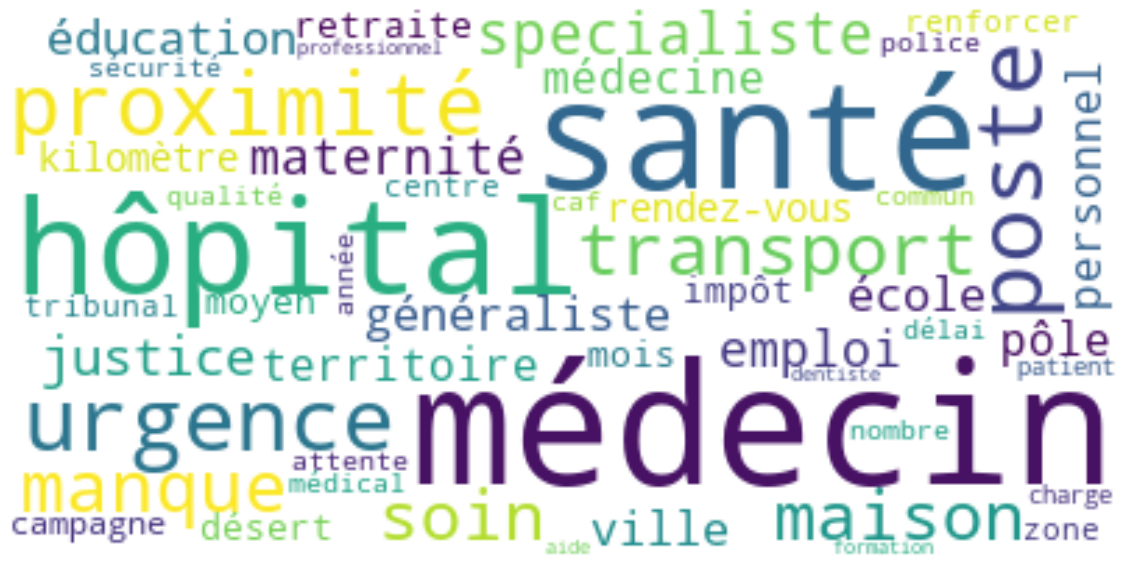

In [11]:

wordcloud = WordCloud(max_words=50,  background_color="white", max_font_size=60).generate_from_frequencies(term_freq_dict)

fig = plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("wordcloud.png", format="png")
plt.show()


In [ ]:
lst = ["a", "b", "c", "d", "e"]
[x for x in lst if x not in ["a", "b"] ]

In [ ]:
model.stages[0].vectors